In [21]:
# 기본 라이브러리
import numpy as np
import pandas as pd
from tqdm import tqdm  # 진행 바 표시

# PyTorch 관련 라이브러리
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# 시각화
import matplotlib.pyplot as plt

# 모델 학습 및 최적화
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 시스템 제어
import time
import random

# 추가: 평가 지표 및 기타
from scipy.sparse import csr_matrix


In [22]:
import numpy as np
import pandas as pd
train = pd.read_parquet("dataset/train.parquet")
test = pd.read_parquet("dataset/test.parquet")


In [60]:
train

,rating,parent_asin,user_id,timestamp
20687409,1.0,0073378151,AE2222HXKLMAEK4SG56OW23V3LTA,1393429135000
25670196,1.0,B01719Y5XK,AE2222WEGI5MUXLFZW6UKKUSI74A,1461552308000
2205090,5.0,B004H4XI0Y,AE22236AFRRSMQIKGG7TPTB75QEA,1326679671000
2205085,4.0,B008P3JNHU,AE22236AFRRSMQIKGG7TPTB75QEA,1370651952000
2205093,5.0,B002PEP4SC,AE22236AFRRSMQIKGG7TPTB75QEA,1259456701000
...,...,...,...,...
14285733,4.0,B06WD8GJ3P,AHZZZYHANWL2OW5PGXDOBUTJXCTA,1516135047122
23959628,5.0,1633224635,AHZZZZ76NI5YF4RP5TKCQRGRQAGA,1521607388514
20325413,5.0,1628603283,AHZZZZUMHA57YCBU4WFINWREUBKQ,1545150722210
9100476,3.0,0894803123,AHZZZZUZCRIUWGMXKFAJO3T5S45A,1379960837000


In [23]:
# 사용자별 등장 빈도 계산
user_freq = train['user_id'].value_counts()

# 상품별 등장 빈도 계산
item_freq = train['parent_asin'].value_counts()

# 빈도 확인
print("상위 5명의 사용자 빈도:")
print(user_freq.head())

print("\n상위 5개의 상품 빈도:")
print(item_freq.head())


상위 5명의 사용자 빈도:
user_id
AGSP6LSQK32SQEJO3YVVNACPWMSQ    2916
AGY5JM4JIEL6RX6X6NLULXZB7DOQ    2214
AG473D27NAWRW3N2RMWVYZ6ICBTA    2204
AF65CA4WVYV6HQI7WQOGR757JHRA    2079
AGWDYYVVWM3DC3CASUZKXK67G6IA    2022
Name: count, dtype: int64

상위 5개의 상품 빈도:
parent_asin
B00L9B7IKE    35985
B006LSZECO    25633
B00JO8PEN2    25399
B00DPM7TIG    16731
B016ZNRC0Q    12884
Name: count, dtype: int64


In [ ]:
# 상위 1000명의 사용자와 상품 선택
top_n_users = user_freq.head(1000).index  # 상위 1000명의 사용자
top_n_items = item_freq.head(1000).index  # 상위 1000개의 상품


In [25]:
filtered_train = train[train['user_id'].isin(top_n_users) & train['parent_asin'].isin(top_n_items)]

In [26]:
num_users = filtered_train['user_id'].nunique()
num_users

804

In [27]:
num_items = filtered_train['parent_asin'].nunique()
num_items

829

In [28]:
# 테스트셋 필터링
filtered_test = test[test['user_id'].isin(top_n_users) & test['parent_asin'].isin(top_n_items)]

# 필터링된 테스트셋의 사용자 및 상품 수 확인
num_test_users = filtered_test['user_id'].nunique()
num_test_items = filtered_test['parent_asin'].nunique()

print(f"테스트셋 사용자 수: {num_test_users}")
print(f"테스트셋 상품 수: {num_test_items}")


테스트셋 사용자 수: 585
테스트셋 상품 수: 602


In [29]:
# 사용자와 상품의 교집합 확인
shared_users = set(filtered_train['user_id']).intersection(set(filtered_test['user_id']))
shared_items = set(filtered_train['parent_asin']).intersection(set(filtered_test['parent_asin']))

print(f"훈련 데이터와 테스트 데이터의 공통 사용자 수: {len(shared_users)}")
print(f"훈련 데이터와 테스트 데이터의 공통 상품 수: {len(shared_items)}")


훈련 데이터와 테스트 데이터의 공통 사용자 수: 556
훈련 데이터와 테스트 데이터의 공통 상품 수: 561


In [30]:
common_user_ratio = len(shared_users) / num_users * 100
print(f"훈련 데이터 사용자 중 테스트 데이터와 겹치는 사용자 비율: {common_user_ratio:.2f}%")


훈련 데이터 사용자 중 테스트 데이터와 겹치는 사용자 비율: 69.15%


In [31]:
common_item_ratio = len(shared_items) / num_items * 100
print(f"훈련 데이터 상품 중 테스트 데이터와 겹치는 상품 비율: {common_item_ratio:.2f}%")


훈련 데이터 상품 중 테스트 데이터와 겹치는 상품 비율: 67.67%


In [32]:
# 테스트 데이터에서만 있는 사용자와 상품 찾기
test_only_users = set(filtered_test['user_id']) - set(filtered_train['user_id'])
test_only_items = set(filtered_test['parent_asin']) - set(filtered_train['parent_asin'])

print(f"테스트에만 있는 사용자 수: {len(test_only_users)}")
print(f"테스트에만 있는 상품 수: {len(test_only_items)}")


테스트에만 있는 사용자 수: 29
테스트에만 있는 상품 수: 41


In [33]:
# 훈련 데이터 사용자와 상품
train_users = set(filtered_train['user_id'])
train_items = set(filtered_train['parent_asin'])

# 테스트 데이터에서 제거: 훈련 데이터에 없는 사용자와 상품을 모두 포함한 경우
filtered_test = filtered_test[
    (filtered_test['user_id'].isin(train_users)) | 
    (filtered_test['parent_asin'].isin(train_items))
]

# 결과 확인
print(f"제거 후 테스트 데이터 크기: {filtered_test.shape[0]} 행")


제거 후 테스트 데이터 크기: 1810 행


In [ ]:
# 사용자와 상품의 고유 ID 추출
all_users = pd.concat([filtered_train['user_id'], filtered_test['user_id']]).unique()
all_items = pd.concat([filtered_train['parent_asin'], filtered_test['parent_asin']]).unique()

# 사용자와 상품 ID를 매핑 (0부터 시작하는 인덱스)
user_map = {user: idx for idx, user in enumerate(all_users)}
item_map = {item: idx for idx, item in enumerate(all_items)}

# 훈련 데이터 매핑
train_r = np.zeros((len(all_items), len(all_users)), dtype=np.float32)
for _, row in filtered_train.iterrows():
    train_r[item_map[row['parent_asin']], user_map[row['user_id']]] = row['rating']

# 테스트 데이터 매핑
test_r = np.zeros((len(all_items), len(all_users)), dtype=np.float32)
for _, row in filtered_test.iterrows():
    test_r[item_map[row['parent_asin']], user_map[row['user_id']]] = row['rating']

print("훈련 데이터 행렬 크기:", train_r.shape)
print("테스트 데이터 행렬 크기:", test_r.shape)


훈련 데이터 행렬 크기: (870, 833)
테스트 데이터 행렬 크기: (870, 833)


In [35]:
print(f"사용자 수: {len(all_users)}, 상품 수: {len(all_items)}")


사용자 수: 833, 상품 수: 870


In [36]:
train_density = np.count_nonzero(train_r) / train_r.size
test_density = np.count_nonzero(test_r) / test_r.size
print(f"훈련 데이터 희소성: {train_density:.2%}")
print(f"테스트 데이터 희소성: {test_density:.2%}")


훈련 데이터 희소성: 0.73%
테스트 데이터 희소성: 0.25%


In [37]:
# PyTorch에서 사용할 장치를 설정합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 사용 중인 장치를 확인합니다.
print(f"Using device: {device}")


Using device: cpu


In [38]:
train_r_tensor = torch.Tensor(train_r).to(device)


In [39]:
def rbf_kernel(u, v):
    dist = torch.norm(u - v, p=2, dim=2)  # L2 거리 계산
    kernel = torch.clamp(1.0 - dist**2, min=0.0)  # RBF 커널 계산
    return kernel


In [40]:
class LocalKernelAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, lambda_s, lambda_2):
        super().__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)  # 인코더
        self.decoder = nn.Linear(hidden_dim, input_dim)  # 디코더

        # RBF 커널 가중치
        self.u = nn.Parameter(torch.randn(input_dim, 1, hidden_dim))
        self.v = nn.Parameter(torch.randn(1, hidden_dim, hidden_dim))

        # 정규화 패널티
        self.lambda_s = lambda_s
        self.lambda_2 = lambda_2

        nn.init.xavier_uniform_(self.u, gain=nn.init.calculate_gain("relu"))
        nn.init.xavier_uniform_(self.v, gain=nn.init.calculate_gain("relu"))

    def forward(self, x):
        encoded = torch.relu(self.encoder(x))  # 인코더
        decoded = torch.sigmoid(self.decoder(encoded))  # 디코더

        # RBF 기반 로컬 커널 가중치 계산
        w_hat = rbf_kernel(self.u, self.v)

        # 정규화 손실 계산
        sparse_reg = torch.nn.functional.mse_loss(w_hat, torch.zeros_like(w_hat))
        l2_reg = torch.nn.functional.mse_loss(self.encoder.weight, torch.zeros_like(self.encoder.weight))
        reg_loss = self.lambda_s * sparse_reg + self.lambda_2 * l2_reg

        return decoded, reg_loss


In [41]:
class GlobalKernelNet(nn.Module):
    def __init__(self, n_m, gk_size, dot_scale):
        super().__init__()
        self.gk_size = gk_size
        self.dot_scale = dot_scale
        self.conv_kernel = nn.Parameter(torch.randn(n_m, gk_size ** 2) * 0.1)  # 아이템 수(n_m) 기반으로 정의

        nn.init.xavier_uniform_(self.conv_kernel, gain=torch.nn.init.calculate_gain("relu"))

    def global_kernel(self, x):
        avg_pooling = torch.mean(x, dim=1)  # 아이템 기반 평균 풀링
        avg_pooling = avg_pooling.view(1, -1)  # (1, n_m)
        gk = torch.matmul(avg_pooling, self.conv_kernel) * self.dot_scale  # (1, gk_size^2)
        gk = gk.view(1, 1, self.gk_size, self.gk_size)  # (1, 1, gk_size, gk_size)
        return gk

    def global_conv(self, x, W):
        x = x.unsqueeze(0).unsqueeze(0)  # 4D 텐서로 변환
        conv2d = F.conv2d(x, W, stride=1, padding=1)  # 2D 컨볼루션
        return conv2d.squeeze(0).squeeze(0)  # 2D 텐서로 복원


In [42]:
class CompleteNet(nn.Module):
    def __init__(self, local_kernel_net, global_kernel_net, gk_size, dot_scale):
        super().__init__()
        self.local_kernel_net = local_kernel_net
        self.global_kernel_net = global_kernel_net
        self.gk_size = gk_size
        self.dot_scale = dot_scale

    def forward(self, x):
        # 로컬 커널 네트워크 출력
        local_output, local_reg_loss = self.local_kernel_net(x)

        # 글로벌 커널 생성 및 적용
        gk = self.global_kernel_net.global_kernel(local_output)
        global_output = self.global_kernel_net.global_conv(local_output, gk)

        # 최종 출력 및 정규화 손실
        final_output = global_output
        reg_loss = local_reg_loss

        return final_output, reg_loss


In [54]:
local_kernel_net = LocalKernelAutoencoder(input_dim=train_r.shape[1], hidden_dim=128, lambda_s=0.01, lambda_2=0.001).to(device)
optimizer = torch.optim.AdamW(local_kernel_net.parameters(), lr=0.001)

for epoch in range(300):
    optimizer.zero_grad()
    pred, reg_loss = local_kernel_net(torch.Tensor(train_r).to(device))
    loss = torch.nn.functional.mse_loss(pred, torch.Tensor(train_r).to(device)) + reg_loss
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")


Epoch 0: Loss = 0.3648752272129059
Epoch 10: Loss = 0.31725358963012695
Epoch 20: Loss = 0.2424953132867813
Epoch 30: Loss = 0.19164741039276123
Epoch 40: Loss = 0.16610123217105865
Epoch 50: Loss = 0.1545332372188568
Epoch 60: Loss = 0.14919276535511017
Epoch 70: Loss = 0.14625012874603271
Epoch 80: Loss = 0.14436088502407074
Epoch 90: Loss = 0.14299574494361877
Epoch 100: Loss = 0.14191141724586487
Epoch 110: Loss = 0.14100436866283417
Epoch 120: Loss = 0.14022627472877502
Epoch 130: Loss = 0.13954003155231476
Epoch 140: Loss = 0.13892428576946259
Epoch 150: Loss = 0.13838008046150208
Epoch 160: Loss = 0.13789932429790497
Epoch 170: Loss = 0.13747182488441467
Epoch 180: Loss = 0.1370907872915268
Epoch 190: Loss = 0.13675011694431305
Epoch 200: Loss = 0.13644443452358246
Epoch 210: Loss = 0.13616923987865448
Epoch 220: Loss = 0.13592082262039185
Epoch 230: Loss = 0.13569608330726624
Epoch 240: Loss = 0.13549232482910156
Epoch 250: Loss = 0.1353072077035904
Epoch 260: Loss = 0.13513870

In [55]:
complete_model = CompleteNet(
    local_kernel_net=local_kernel_net,
    global_kernel_net=GlobalKernelNet(n_m=train_r.shape[0], gk_size=3, dot_scale=0.1).to(device),
    gk_size=3,
    dot_scale=0.1
).to(device)


In [56]:
# 손실 값을 저장할 리스트
losses = []

# 학습 루프
optimizer = torch.optim.AdamW(complete_model.parameters(), lr=0.001)

for epoch in range(300):
    optimizer.zero_grad()
    pred, reg_loss = complete_model(torch.Tensor(train_r).to(device))
    loss = torch.nn.functional.mse_loss(pred, torch.Tensor(train_r).to(device)) + reg_loss
    loss.backward()
    optimizer.step()

    # 손실 값 기록
    losses.append(loss.item())

    # 10 에포크마다 출력
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")


Epoch 0: Loss = 0.13646873831748962
Epoch 10: Loss = 0.13635726273059845
Epoch 20: Loss = 0.13604629039764404
Epoch 30: Loss = 0.1355307698249817
Epoch 40: Loss = 0.1344522386789322
Epoch 50: Loss = 0.1324932724237442
Epoch 60: Loss = 0.12875017523765564
Epoch 70: Loss = 0.1218298077583313
Epoch 80: Loss = 0.11097400635480881
Epoch 90: Loss = 0.09656800329685211
Epoch 100: Loss = 0.08126424998044968
Epoch 110: Loss = 0.06965399533510208
Epoch 120: Loss = 0.06224182993173599
Epoch 130: Loss = 0.057779066264629364
Epoch 140: Loss = 0.05475494638085365
Epoch 150: Loss = 0.05257460102438927
Epoch 160: Loss = 0.05081065371632576
Epoch 170: Loss = 0.0492544025182724
Epoch 180: Loss = 0.047836966812610626
Epoch 190: Loss = 0.046503908932209015
Epoch 200: Loss = 0.045234039425849915
Epoch 210: Loss = 0.044001396745443344
Epoch 220: Loss = 0.04276555776596069
Epoch 230: Loss = 0.04148201271891594
Epoch 240: Loss = 0.04017919674515724
Epoch 250: Loss = 0.0387895405292511
Epoch 260: Loss = 0.0372

In [57]:
# 테스트 데이터로 모델 평가
test_r_tensor = torch.Tensor(test_r).to(device)

complete_model.eval()  # 모델을 평가 모드로 설정
with torch.no_grad():
    pred, _ = complete_model(test_r_tensor)  # 테스트 데이터로 예측 수행
    pred = pred.cpu().numpy()  # 예측값을 NumPy 배열로 변환

# RMSE 계산
rmse = np.sqrt(np.mean((test_r - pred) ** 2))
print(f"Test RMSE: {rmse}")

# MAE 계산
mae = np.mean(np.abs(test_r - pred))
print(f"Test MAE: {mae}")

# NDCG 계산 함수 (예: Top-K 기준)
def calculate_ndcg(predictions, ground_truth, k=10):
    def dcg(scores):
        return np.sum((2**scores - 1) / np.log2(np.arange(1, len(scores) + 1) + 1))
    
    ndcg_scores = []
    for pred_row, true_row in zip(predictions, ground_truth):
        top_k_indices = np.argsort(pred_row)[::-1][:k]
        true_relevance = true_row[top_k_indices]
        ideal_relevance = np.sort(true_row)[::-1][:k]
        dcg_score = dcg(true_relevance)
        idcg_score = dcg(ideal_relevance)
        ndcg_scores.append(dcg_score / idcg_score if idcg_score > 0 else 0.0)
    return np.mean(ndcg_scores)

# NDCG 계산
ndcg = calculate_ndcg(np.clip(pred, 1., 5.), test_r, k=10)
print(f"Test NDCG@10: {ndcg}")


Test RMSE: 0.3974338173866272
Test MAE: 0.3030995726585388
Test NDCG@10: 0.5858089664503401


In [58]:
import numpy as np

# Precision@k 계산 함수
def calculate_precision_recall(pred, actual, k=10):
    """
    Precision@k와 Recall@k를 계산하는 함수
    :param pred: 예측된 아이템 목록
    :param actual: 실제 관심 있는 아이템 목록
    :param k: 평가할 추천 목록의 길이 (예: 10)
    :return: Precision@k, Recall@k
    """
    # 상위 k개의 추천 아이템
    recommended_items = np.argsort(pred, axis=1)[:, -k:]  # 예측된 아이템의 상위 k개
    true_positives = 0
    for i in range(pred.shape[0]):
        # 실제 긍정적인 항목이 상위 k개 추천에 포함되었는지 확인
        true_positives += len(set(recommended_items[i]) & set(actual[i]))

    # Precision@k
    precision = true_positives / (k * len(pred))

    # Recall@k
    recall = true_positives / len(actual)
    
    return precision, recall

# F1-Score@k 계산 함수
def calculate_f1_score(precision, recall):
    """
    Precision과 Recall을 기반으로 F1-Score를 계산하는 함수
    :param precision: Precision@k
    :param recall: Recall@k
    :return: F1-Score@k
    """
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

# NDCG@k 계산 함수
def calculate_ndcg(predictions, ground_truth, k=10):
    """
    NDCG@k 계산 함수
    :param predictions: 예측된 아이템 목록
    :param ground_truth: 실제 관심 있는 아이템 목록
    :param k: 평가할 추천 목록의 길이 (예: 10)
    :return: NDCG@k
    """
    def dcg(scores):
        return np.sum((2**scores - 1) / np.log2(np.arange(1, len(scores) + 1) + 1))
    
    ndcg_scores = []
    for pred_row, true_row in zip(predictions, ground_truth):
        top_k_indices = np.argsort(pred_row)[::-1][:k]
        true_relevance = true_row[top_k_indices]
        ideal_relevance = np.sort(true_row)[::-1][:k]
        dcg_score = dcg(true_relevance)
        idcg_score = dcg(ideal_relevance)
        ndcg_scores.append(dcg_score / idcg_score if idcg_score > 0 else 0.0)
    return np.mean(ndcg_scores)

# 테스트 데이터로 모델 평가
test_r_tensor = torch.Tensor(test_r).to(device)

complete_model.eval()  # 모델을 평가 모드로 설정
with torch.no_grad():
    pred, reg_loss = complete_model(test_r_tensor)  # 테스트 데이터로 예측 수행
    pred = pred.cpu().numpy()  # 예측값을 NumPy 배열로 변환

# RMSE 계산
rmse = np.sqrt(np.mean((test_r - pred) ** 2))
print(f"Test RMSE: {rmse}")

# MAE 계산
mae = np.mean(np.abs(test_r - pred))
print(f"Test MAE: {mae}")

# Precision, Recall, F1-Score 계산
precision, recall = calculate_precision_recall(np.clip(pred, 1., 5.), test_r, k=10)
f1_score = calculate_f1_score(precision, recall)
print(f"Test Precision@10: {precision}")
print(f"Test Recall@10: {recall}")
print(f"Test F1-Score@10: {f1_score}")

# NDCG 계산
ndcg = calculate_ndcg(np.clip(pred, 1., 5.), test_r, k=10)
print(f"Test NDCG@10: {ndcg}")


Test RMSE: 0.3974338173866272
Test MAE: 0.3030995726585388
Test Precision@10: 0.001379310344827586
Test Recall@10: 0.013793103448275862
Test F1-Score@10: 0.002507836990595611
Test NDCG@10: 0.5858089664503401


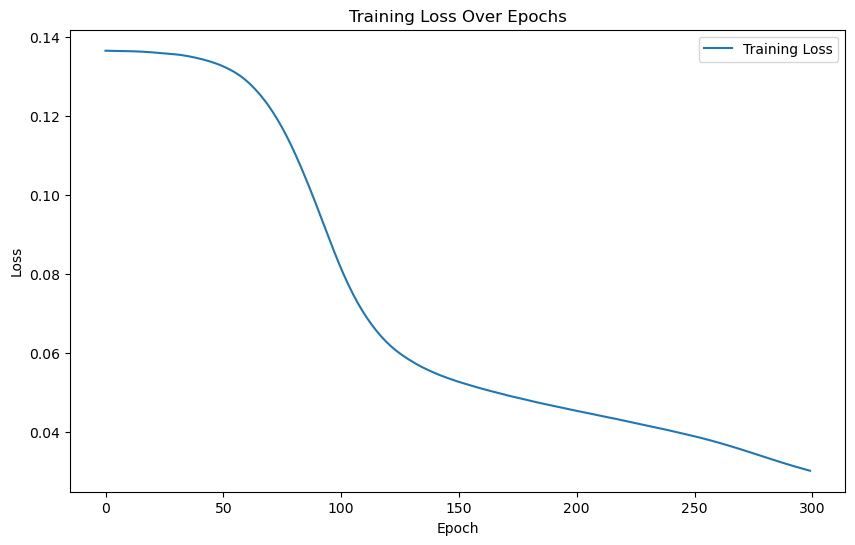

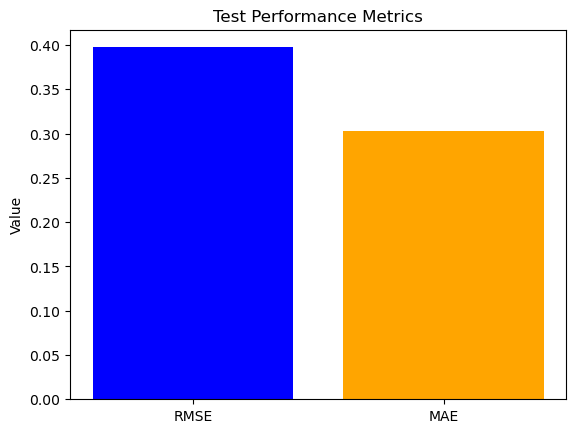

In [59]:
# 학습 중 손실 값 시각화
plt.figure(figsize=(10, 6))
plt.plot(losses, label="Training Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 테스트 RMSE와 MAE 시각화
metrics = {"RMSE": rmse, "MAE": mae}
plt.bar(metrics.keys(), metrics.values(), color=["blue", "orange"])
plt.title("Test Performance Metrics")
plt.ylabel("Value")
plt.show()
